In [102]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

In [103]:
# Funcion para agregar las señales de MACD
def add_macd_signals(df):
    df['MACD_Buy_Signal_lag1'] = (
        (df['MACD_12_26_9_lag1'] > df['MACDs_12_26_9_lag1']) &
        (df['MACD_12_26_9_lag1'].shift(1) <= df['MACDs_12_26_9_lag1'].shift(1))
    ).astype(int)

    df['MACD_Sell_Signal_lag1'] = (
        (df['MACD_12_26_9_lag1'] < df['MACDs_12_26_9_lag1']) &
        (df['MACD_12_26_9_lag1'].shift(1) >= df['MACDs_12_26_9_lag1'].shift(1))
    ).astype(int)

    return df

# Funcion para agregar las señales de Bollinger Bands
def add_bollinger_features(df):
    df['BBW_lag1']             = df['BBU_20_2.0_lag1'] - df['BBL_20_2.0_lag1']
    df['BB%B_lag1']            = (df['Close_lag_1'] - df['BBL_20_2.0_lag1']) / (df['BBU_20_2.0_lag1'] - df['BBL_20_2.0_lag1'])
    df['Squeeze_lag1']         = (df['BBB_20_2.0_lag1'] < 0.02).astype(int)
    df['Breakout_lag1']        = (
        (df['Close_lag_1'] > df['BBU_20_2.0_lag1']) |
        (df['Close_lag_1'] < df['BBL_20_2.0_lag1'])
    ).astype(int)
    df['Dist_from_Middle_lag1'] = df['Close_lag_1'] - df['BBM_20_2.0_lag1']
    df['Z_Score_lag1']         = df['Dist_from_Middle_lag1'] / ((df['BBU_20_2.0_lag1'] - df['BBM_20_2.0_lag1']) / 2)
    df['BB_Ratio_lag1']        = df['BBU_20_2.0_lag1'] / df['BBL_20_2.0_lag1']
    
    return df

def add_lag1_technical_indicators(df):
    df['Close_lag_1'] = df['Close'].shift(1)

    # SMA y RSI sobre Close_lag_1
    df['SMA_20_lag1'] = ta.sma(df['Close_lag_1'], length=20)
    df['SMA_50_lag1'] = ta.sma(df['Close_lag_1'], length=50)
    df['RSI_14_lag1'] = ta.rsi(df['Close_lag_1'], length=14)

    # MACD sobre Close_lag_1
    macd = ta.macd(df['Close_lag_1'])
    macd = macd.rename(columns={
        'MACD_12_26_9':  'MACD_12_26_9_lag1',
        'MACDh_12_26_9': 'MACDh_12_26_9_lag1',
        'MACDs_12_26_9': 'MACDs_12_26_9_lag1'
    })
    df = pd.concat([df, macd], axis=1)

    # Bollinger Bands sobre Close_lag_1
    bb = ta.bbands(df['Close_lag_1'], length=20)
    bb = bb.rename(columns={
        'BBL_20_2.0': 'BBL_20_2.0_lag1',
        'BBM_20_2.0': 'BBM_20_2.0_lag1',
        'BBU_20_2.0': 'BBU_20_2.0_lag1',
        'BBB_20_2.0': 'BBB_20_2.0_lag1',
        'BBP_20_2.0': 'BBP_20_2.0_lag1'
    })
    df = pd.concat([df, bb], axis=1)  

    df = add_bollinger_features(df)
    df = add_macd_signals(df) 

    return df

#Funcion para agregar las features de covid
def add_covid_info(df):
    df['days_since_covid_begin'] = (df['Date'] - pd.to_datetime('2020-03-11')).dt.days
    df['days_since_covid_end'] = (df['Date'] - pd.to_datetime('2023-05-05')).dt.days
    return df

#Funcion para agregar las features de estaciones
def add_seasons(df, as_dummies=False):
    month = df['Date'].dt.month
    df['season'] = month.map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
    })

    if as_dummies:
        season_dummies = pd.get_dummies(df['season'], prefix='season', drop_first=True)
        df = df.drop(columns='season')
        df = pd.concat([df, season_dummies], axis=1)

    return df

def day_month_year(df):
    df['day'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['day_of_week'] = df['Date'].dt.dayofweek
    return df

#Funcion para agregar las features de lags
def lag_features(df, target_col, lags):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

# Funcion para agregar todas las features generadas
def feature_engineering(df):
    print(f"Dataset before feature engineering: {df.shape}")
    df['Date'] = pd.to_datetime(df['Date'])
    # df = add_lag1_technical_indicators(df)
    df = add_covid_info(df)
    df = add_seasons(df, as_dummies=True)
    df = day_month_year(df)
    df = lag_features(df, 'Close', list(range(1, 16)))
    for col in [col for col in df.columns if 'SP500' in col]:
        df = lag_features(df, col, [1])
        df.drop(columns=[col], inplace=True)

    for col in ['Volume', 'Open', 'High', 'Low']:
        df = lag_features(df, col, [1])
        df.drop(columns=[col], inplace=True)

    df.dropna(inplace=True)
    df.drop(columns=['Date'], inplace=True)
    
    print(f"Dataset after feature engineering: {df.shape}")
    return df

In [104]:
apple_data = pd.read_csv('../data/processed/AAPL_with_SP500_clean.csv')
apple_data= apple_data[apple_data['Date']>'2022-01-01']

apple_data = feature_engineering(apple_data)

print(apple_data.columns)

Dataset before feature engineering: (792, 11)
Dataset after feature engineering: (777, 34)
Index(['Close', 'days_since_covid_begin', 'days_since_covid_end',
       'season_Spring', 'season_Summer', 'season_Winter', 'day', 'month',
       'year', 'day_of_week', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3',
       'Close_lag_4', 'Close_lag_5', 'Close_lag_6', 'Close_lag_7',
       'Close_lag_8', 'Close_lag_9', 'Close_lag_10', 'Close_lag_11',
       'Close_lag_12', 'Close_lag_13', 'Close_lag_14', 'Close_lag_15',
       'Open_SP500_lag_1', 'High_SP500_lag_1', 'Low_SP500_lag_1',
       'Close_SP500_lag_1', 'Volume_SP500_lag_1', 'Volume_lag_1', 'Open_lag_1',
       'High_lag_1', 'Low_lag_1'],
      dtype='object')


In [105]:

apple_data.drop(columns=['Volume_lag_1', 'Volume_SP500_lag_1', 'High_lag_1','Low_lag_1', 'Open_lag_1','Close_lag_1'
                         , 'Open_SP500_lag_1', 'High_SP500_lag_1','Low_SP500_lag_1', 'Close_SP500_lag_1', 'days_since_covid_begin'
                            , 'days_since_covid_end', 'day', 'month', 'year', 'day_of_week'
                         ], inplace=True)
apple_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 777 entries, 10367 to 11143
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Close          777 non-null    float64
 1   season_Spring  777 non-null    bool   
 2   season_Summer  777 non-null    bool   
 3   season_Winter  777 non-null    bool   
 4   Close_lag_2    777 non-null    float64
 5   Close_lag_3    777 non-null    float64
 6   Close_lag_4    777 non-null    float64
 7   Close_lag_5    777 non-null    float64
 8   Close_lag_6    777 non-null    float64
 9   Close_lag_7    777 non-null    float64
 10  Close_lag_8    777 non-null    float64
 11  Close_lag_9    777 non-null    float64
 12  Close_lag_10   777 non-null    float64
 13  Close_lag_11   777 non-null    float64
 14  Close_lag_12   777 non-null    float64
 15  Close_lag_13   777 non-null    float64
 16  Close_lag_14   777 non-null    float64
 17  Close_lag_15   777 non-null    float64
dtypes: bool(3

<class 'pandas.core.frame.DataFrame'>
Index: 621 entries, 11106 to 10469
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season_Spring  621 non-null    bool   
 1   season_Summer  621 non-null    bool   
 2   season_Winter  621 non-null    bool   
 3   Close_lag_2    621 non-null    float64
 4   Close_lag_3    621 non-null    float64
 5   Close_lag_4    621 non-null    float64
 6   Close_lag_5    621 non-null    float64
 7   Close_lag_6    621 non-null    float64
 8   Close_lag_7    621 non-null    float64
 9   Close_lag_8    621 non-null    float64
 10  Close_lag_9    621 non-null    float64
 11  Close_lag_10   621 non-null    float64
 12  Close_lag_11   621 non-null    float64
 13  Close_lag_12   621 non-null    float64
 14  Close_lag_13   621 non-null    float64
 15  Close_lag_14   621 non-null    float64
 16  Close_lag_15   621 non-null    float64
dtypes: bool(3), float64(14)
memory usage: 74.6 KB
None
MS

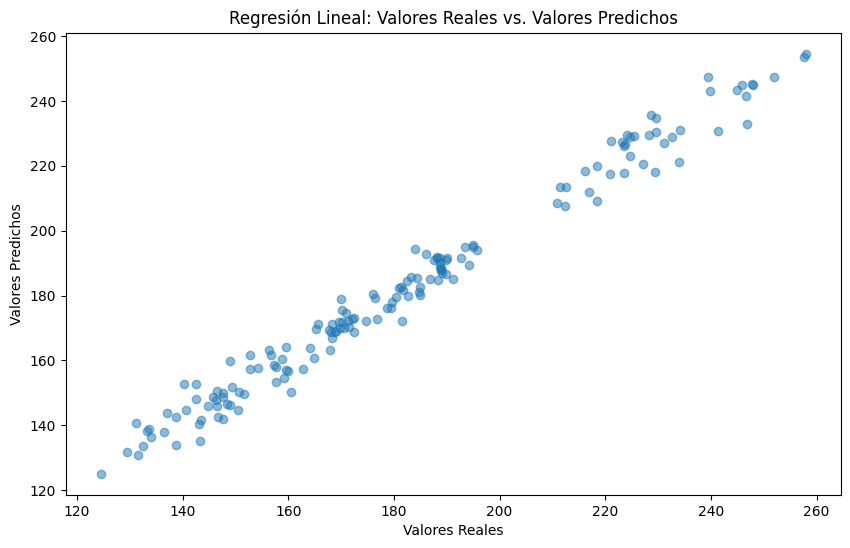

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Preparar los datos para el entrenamiento
train_data, test_data = train_test_split(apple_data, test_size=0.2, random_state=42)

y_train = train_data['Close']
X_train = train_data.drop(columns=['Close'])
print(X_train.info())

y_test = test_data['Close']
X_test = test_data.drop(columns=['Close'])   

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)  

print(f"MSE: {mse}")
print(f"R2: {r2}")

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Regresión Lineal: Valores Reales vs. Valores Predichos')
plt.show()